In [138]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
import cv2
# set the matplotlib backend so figures can be saved in the background
import matplotlib .pyplot as plt
# import the necessary packages
from sklearn import svm
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras import backend as K
from keras.utils import to_categorical
from keras.models import model_from_json
import random

# Any results you write to the current directory are saved as output.

['owncollection']


In [45]:
data = []
labels = []

for paths, dirs,files in os.walk('../input/owncollection'):
    imagesPath = sorted([images for images in files])
    #print(imagesPath)
    #print(paths)
    for imagePath in imagesPath:
        image = cv2.imread('../input/owncollection/OwnCollection/' + paths.split('/')[4] + '/' + paths.split('/')[5] + '/' + imagePath)
        image = cv2.resize(image, (64,64)).flatten()
        data.append(image)
        labels.append(paths.split('/')[4])

print(len(data))
print(len(labels))

7325
7325


In [46]:
data = np.array(data, dtype='float32') / 255.0
labels = np.array(labels)

In [47]:
data.shape

(7325, 12288)

In [48]:
labels.shape

(7325,)

In [49]:
data[:100]

array([[0.32941177, 0.35686275, 0.33333334, ..., 0.30980393, 0.34509805,
        0.3137255 ],
       [0.42745098, 0.4862745 , 0.45882353, ..., 0.37254903, 0.40784314,
        0.3764706 ],
       [0.35686275, 0.40392157, 0.3764706 , ..., 0.3019608 , 0.30588236,
        0.24313726],
       ...,
       [0.41960785, 0.42745098, 0.4       , ..., 0.36078432, 0.37254903,
        0.3254902 ],
       [0.32941177, 0.30980393, 0.2627451 , ..., 0.25882354, 0.25490198,
        0.19215687],
       [0.28627452, 0.2627451 , 0.23137255, ..., 0.24705882, 0.23921569,
        0.1882353 ]], dtype=float32)

In [50]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.25, random_state=42)

In [51]:
trainY.shape

(5493,)

In [52]:
testY.shape

(1832,)

In [53]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [54]:
trainY

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [55]:
print(trainY.shape)
print(testY.shape)

(5493, 1)
(1832, 1)


## First making a SVM classifier to predict the classes, since the SVM classifiers generally do better with HOG features, and since I am making this model to for detection of cars in a video, I will be making use of a kernel SVM.

In [57]:
clf = svm.SVC(kernel='rbf', gamma = 'auto',random_state=0)
clf.fit(trainX, trainY)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [78]:
image = cv2.imread('../input/owncollection/OwnCollection/vehicles/Right/image0001.png')
image = cv2.resize(image, (64,64)).flatten()
image = image.astype('float') / 255
image = image.reshape((1, image.shape[0]))
image.shape

(1, 12288)

In [79]:
preds = clf.predict(image)
print(preds)
label = lb.classes_[preds]
print(label)

[1]
['vehicles']


In [80]:
y_pred = clf.predict(testX)

In [83]:
y_pred.shape

(1832,)

In [84]:
y_pred[:10]

array([1, 0, 1, 1, 0, 1, 1, 1, 0, 1])

In [85]:
cm = confusion_matrix(testY, y_pred)
print(cm)

[[886  88]
 [ 83 775]]


In [86]:
score = accuracy_score(testY, y_pred)

In [87]:
score

0.9066593886462883

## So , as seen, we get a whopping 90% score on the model , which is pretty descent for a classifier

---

## Now , I'll be using a CNN for the same task, which is my simple version of the VGG - CNN architechture .

In [88]:
class SmallVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # If the we are using 'channels first', then we need to update the input shape
        # and channels dimentions
        if K.image_data_format() == 'channels_first':
            inputShape = (depth, height, width)
            chanDim = 1
            
        model.add(Conv2D(32, (3,3), padding = 'same' ,input_shape = inputShape))
        model.add(Activation('relu'))
        ## To normalize the data along the channel dimention, to reduce training time and stabilize
        ## the network.
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # (CONV => RELU) * 2 => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # (CONV => RELU) * 3 => POOL layer set
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [113]:
data = []
labels = []

for paths, dirs,files in os.walk('../input/owncollection'):
    imagesPath = sorted([images for images in files])
    #print(imagesPath)
    #print(paths)
    for imagePath in imagesPath:
        image = cv2.imread('../input/owncollection/OwnCollection/' + paths.split('/')[4] + '/' + paths.split('/')[5] + '/' + imagePath)
        image = cv2.resize(image, (64,64))
        data.append(image)
        labels.append(paths.split('/')[4])

print(len(data))
print(len(labels))



7325
7325


In [114]:
data[:3]

[array([[[ 84,  91,  85],
         [ 87,  94,  86],
         [ 86,  93,  87],
         ...,
         [ 91, 103,  94],
         [ 92, 102,  95],
         [ 93, 101,  97]],
 
        [[ 84,  91,  84],
         [ 86,  93,  85],
         [ 84,  91,  84],
         ...,
         [ 93, 105,  95],
         [ 93, 103,  95],
         [ 93, 102,  96]],
 
        [[ 84,  91,  84],
         [ 84,  91,  83],
         [ 82,  89,  82],
         ...,
         [ 93, 105,  96],
         [ 94, 104,  96],
         [ 94, 103,  96]],
 
        ...,
 
        [[ 79,  83,  78],
         [ 79,  83,  78],
         [ 79,  83,  78],
         ...,
         [ 79,  89,  80],
         [ 79,  89,  80],
         [ 81,  91,  83]],
 
        [[ 82,  86,  81],
         [ 82,  86,  81],
         [ 80,  84,  79],
         ...,
         [ 81,  90,  81],
         [ 79,  89,  79],
         [ 80,  90,  80]],
 
        [[ 82,  86,  81],
         [ 81,  85,  80],
         [ 80,  84,  79],
         ...,
         [ 81,  90,  81],
  

In [115]:
data = np.array(data, dtype='float32') / 255.0
# since the pixel intensities lies from 0 to 255, thus we normalized the data to 0 to 1
labels = np.array(labels)
print(data.shape)
print(labels.shape)

(7325, 64, 64, 3)
(7325,)


In [116]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.25, random_state=42)

In [119]:
## Here We are just doing the one-hot encoding for the labels.
labelencoder_y_1 = LabelEncoder()
trainY = labelencoder_y_1.fit_transform(trainY)
testY = labelencoder_y_1.transform(testY)

In [121]:
print(trainY.shape, testY.shape)
# construct the image generator for data augmentation
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                        height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                        horizontal_flip=True, fill_mode="nearest")
 
"""
Image augmentation allows us to construct “additional” training data from our existing training data by randomly rotating, shifting, shearing, zooming, and flipping.

Data augmentation is often a critical step to:

1) Avoiding overfitting
2) Ensuring your model generalizes well
"""
    
# initialize our VGG-like Convolutional Neural Network
model = SmallVGGNet.build(width=64, height=64, depth=3,classes=len(labelencoder_y_1.classes_))

(5493,) (1832,)


In [125]:
# initialize our initial learning rate, # of epochs to train for,
# and batch size
INIT_LR = 0.01
EPOCHS = 100
BS = 32
# initialize the model and optimizer 
print("[INFO] training network...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the network
h = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
                                validation_data=(testX, testY), 
                                steps_per_epoch=len(trainX) // BS,
                                epochs=EPOCHS)

[INFO] training network...
Epoch 1/100
171/171 [==============================] - 12s 71ms/step - loss: 0.2169 - acc: 0.9237 - val_loss: 0.8661 - val_acc: 0.7162
Epoch 2/100
171/171 [==============================] - 11s 62ms/step - loss: 0.1664 - acc: 0.9386 - val_loss: 0.6457 - val_acc: 0.7303
Epoch 3/100
171/171 [==============================] - 10s 60ms/step - loss: 0.1352 - acc: 0.9477 - val_loss: 0.1453 - val_acc: 0.9492
Epoch 4/100
171/171 [==============================] - 10s 60ms/step - loss: 0.1232 - acc: 0.9564 - val_loss: 0.6589 - val_acc: 0.7817
Epoch 5/100
171/171 [==============================] - 10s 60ms/step - loss: 0.1070 - acc: 0.9587 - val_loss: 0.0600 - val_acc: 0.9771
Epoch 6/100
171/171 [==============================] - 10s 60ms/step - loss: 0.1064 - acc: 0.9635 - val_loss: 0.0854 - val_acc: 0.9700
Epoch 7/100
171/171 [==============================] - 11s 63ms/step - loss: 0.0889 - acc: 0.9687 - val_loss: 0.0697 - val_acc: 0.9771
Epoch 8/100
171/171 [=======

171/171 [==============================] - 10s 58ms/step - loss: 0.0214 - acc: 0.9923 - val_loss: 0.0393 - val_acc: 0.9885
Epoch 62/100
171/171 [==============================] - 10s 60ms/step - loss: 0.0281 - acc: 0.9898 - val_loss: 0.0342 - val_acc: 0.9907
Epoch 63/100
171/171 [==============================] - 10s 59ms/step - loss: 0.0296 - acc: 0.9889 - val_loss: 0.0381 - val_acc: 0.9874
Epoch 64/100
171/171 [==============================] - 10s 58ms/step - loss: 0.0342 - acc: 0.9865 - val_loss: 0.0624 - val_acc: 0.9798
Epoch 65/100
171/171 [==============================] - 10s 58ms/step - loss: 0.0235 - acc: 0.9914 - val_loss: 0.0207 - val_acc: 0.9956
Epoch 66/100
171/171 [==============================] - 10s 58ms/step - loss: 0.0316 - acc: 0.9888 - val_loss: 0.0241 - val_acc: 0.9918
Epoch 67/100
171/171 [==============================] - 10s 59ms/step - loss: 0.0235 - acc: 0.9923 - val_loss: 0.0276 - val_acc: 0.9896
Epoch 68/100
171/171 [==============================] - 10s 6

[INFO] evaluating network...
              precision    recall  f1-score   support

non-vehicles       0.99      0.99      0.99       974
    vehicles       0.99      0.99      0.99       858

   micro avg       0.99      0.99      0.99      1832
   macro avg       0.99      0.99      0.99      1832
weighted avg       0.99      0.99      0.99      1832



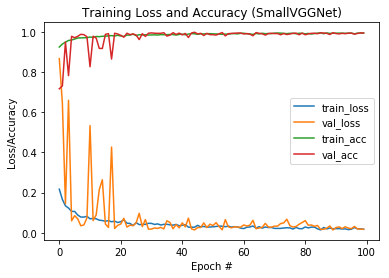

In [128]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY,
                            predictions.argmax(axis=1), target_names=labelencoder_y_1.classes_))
 
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.figure()
plt.plot(N, h.history["loss"], label="train_loss")
plt.plot(N, h.history["val_loss"], label="val_loss")
plt.plot(N, h.history["acc"], label="train_acc")
plt.plot(N, h.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy (SmallVGGNet)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [131]:
image = cv2.imread('../input/owncollection/OwnCollection/non-vehicles/Far/image0000.png')
image = cv2.resize(image, (64,64))
image = image.astype('float') / 255.0
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image.shape

(1, 64, 64, 3)

In [132]:
preds = model.predict(image)
i = preds.argmax(axis=1)[0]
label = labelencoder_y_1.classes_[i]
print(preds, label)

[[1.0000000e+00 1.2448259e-12]] non-vehicles


In [133]:
image = cv2.imread('../input/owncollection/OwnCollection/vehicles/Far/image0000.png')
image = cv2.resize(image, (64,64))
image = image.astype('float') / 255.0
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image.shape

(1, 64, 64, 3)

In [134]:
preds = model.predict(image)
i = preds.argmax(axis=1)[0]
label = labelencoder_y_1.classes_[i]
print(preds, label)

[[5.344577e-07 9.999995e-01]] vehicles


In [135]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 

Saved model to disk


In [139]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 

Loaded model from disk
